In [36]:
%matplotlib inline
!pip install deeptrack==0.11.3

# Example 3. Single particle sizing



## 1. Setup

Imports the objects needed for this example.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

from deeptrack.extras import datasets
datasets.load('ParticleSizing')

import scipy.io as IO

IMAGE_SIZE = 128

ParticleSizing already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 64 by 64 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 100nm and 400nm, and a refractive index between 1.37 and 1.67. Its position in the camera plane is constrained to be within within two pixels of the image center, and is sampled with a normal distribution with standard deviation of 2 pixel units along the axis normal to the camera plane. 

In [38]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE/2 + IMAGE_SIZE/30 * np.random.randn(), IMAGE_SIZE/2+IMAGE_SIZE/30*np.random.randn()),
    z=lambda: -150 + np.random.random() * 300,
    radius=lambda:1e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.3) + 1.37,
    L=8,
    position_unit="pixel",
)

We use a single wavelengtj brightifeld feature to calculate the field at the camera plane. We aberrate the image with a random coma, which was observed in the experimental data. Moreover, the pupil is cropped at high frequencies.

In [39]:
HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=23)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil= HC + VC + CROP
)

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. The amplitude of the noise is determined by the dummy property `level`, which is explicitly shared between the two features. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [40]:
real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: np.random.rand() * 0.0,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.0j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 3e-4 * 0,
)

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [41]:
dataset = optics(particle + noise + gradient) + complex_to_float

### 2.2 Defining the training label

We extract the parameters we want the network to learn. We also rescale them such that they have a similar size.

In [42]:
def get_label(image):
    return np.array([image.get_property("z")])

# 2.3 Visualizing the dataset

We resolve and show 16 images

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


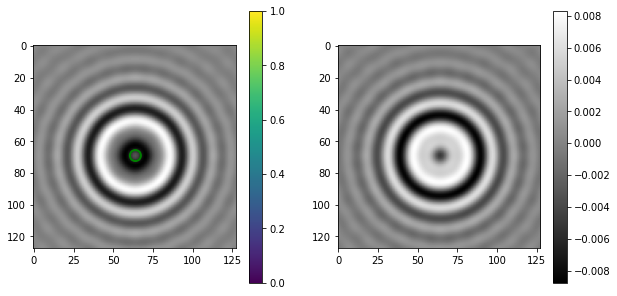

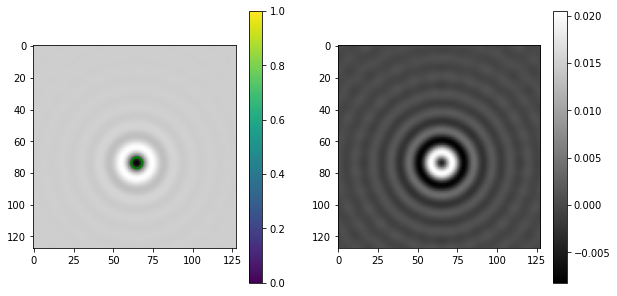

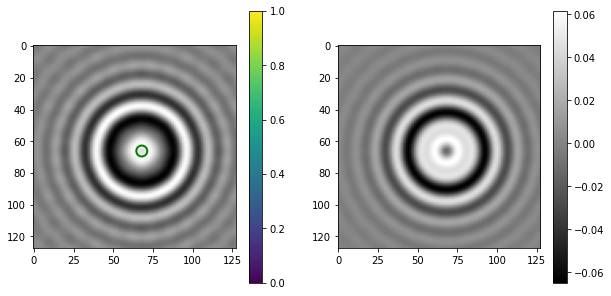

In [43]:
NUMBER_OF_IMAGES = 3

for i in range(NUMBER_OF_IMAGES):
    dataset.update()
    image_of_particle = dataset.resolve()
    position_of_particle = image_of_particle.get_property("position")
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image_of_particle[:, :, 0], cmap="gray")
    plt.scatter(position_of_particle[1], position_of_particle[0], s=120, facecolors='none', edgecolors="g", linewidth=2)
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(image_of_particle[:, :, 1], cmap="gray")
    plt.colorbar()
    plt.show()


## 3. Defining the network

The network used is a Convolutional network, with a the pixel error as loss.

In [44]:
import keras.backend as K
import keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions=(32, 64, 64, 64, 64),
    dense_layers_dimensions=(32, 32),
    steps_per_pooling=2,
    number_of_outputs=1,
    dropout=(.5, .5),
    loss="mae",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="relu")
)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 2)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      608       
                                                                 
 activation_24 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 activation_25 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 spatial_dropout2d_6 (Spatia  (None, 128, 128, 32)     0         
 lDropout2D)                                                     
                                                           

In [45]:
from keras.models import Model, Sequential
from keras import backend as K

def create_dropout_predict_function(model, dropout):
    """
    Create a keras function to predict with dropout
    model : keras model
    dropout : fraction dropout to apply to all layers
    
    Returns
    predict_with_dropout : keras function for predicting with dropout
    """
    
    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
        # Dropout layers
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
        # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # Create a new model with specified dropout
    if type(model)==Sequential:
        # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
        # Functional
        model_dropout = Model.from_config(conf)
    model_dropout.set_weights(model.get_weights()) 
    
    # Create a function to predict with the dropout on
    predict_with_dropout = K.function(model_dropout.inputs+[K.learning_phase()], model_dropout.outputs)
    
    return predict_with_dropout

## 4. Training the network

We use the `ContinuousGenerator` to generate the images. It creates a new therad and generates images while the model is training. 

Set TRAIN_MODEL to True to train the model, otherwise a pretrained model is downloaded.

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


Generating 1285 / 1280 samples before starting training
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 77.1918
Epoch 00001: saving model to START/firstmodel.ckpt
10/10 [==============================] - 103s 10s/step - loss: 77.1918 - val_loss: 74.4417
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 70.7746
Epoch 00002: saving model to START/firstmodel.ckpt
10/10 [==============================] - 100s 10s/step - loss: 70.7746 - val_loss: 54.9348
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 48.2780
Epoch 00003: saving model to START/firstmodel.ckpt
10/10 [==============================] - 100s 10s/step - loss: 48.2780 - val_loss: 41.7590
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 42.0970 
Epoch 00004: saving model to START/firstmodel.ckpt
10/10 [==============================] - 112s 11s/step - loss: 42.0970 - val_loss: 34.3511
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 35.

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


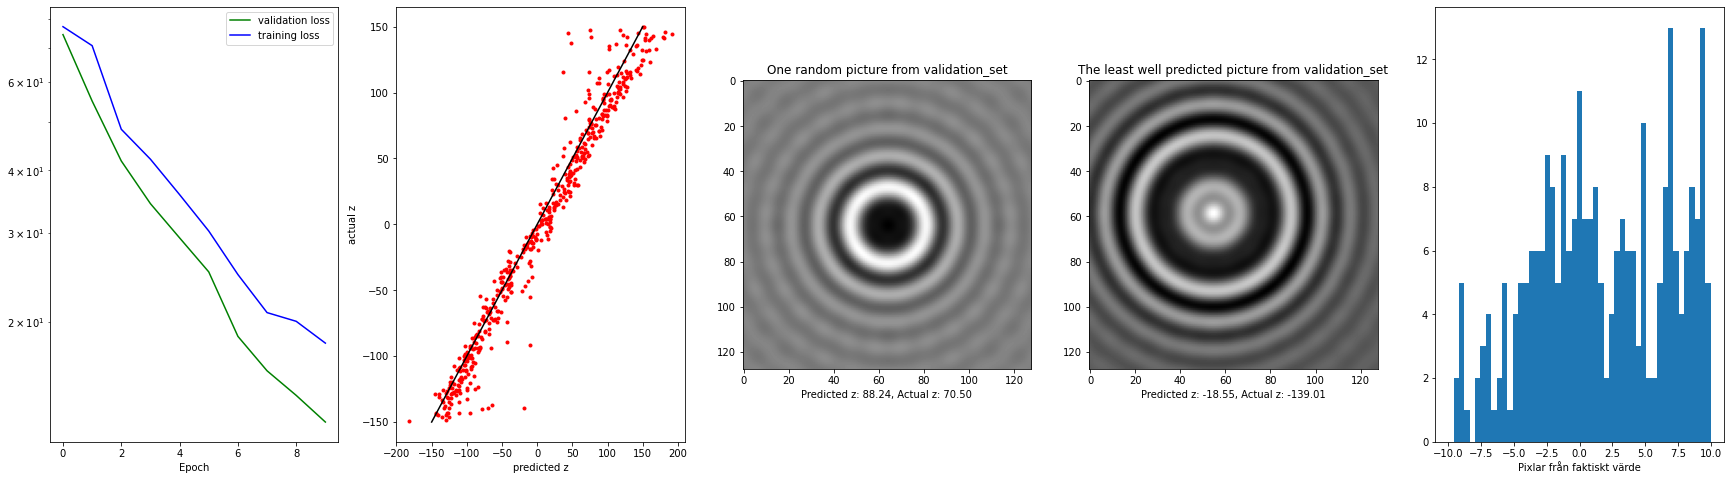

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 15.8170
Epoch 00001: saving model to START/firstmodel.ckpt
20/20 [==============================] - 193s 10s/step - loss: 15.8170 - val_loss: 10.0095
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 15.4076
Epoch 00002: saving model to START/firstmodel.ckpt
20/20 [==============================] - 196s 10s/step - loss: 15.4076 - val_loss: 8.8361
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 14.7432
Epoch 00003: saving model to START/firstmodel.ckpt
20/20 [==============================] - 194s 10s/step - loss: 14.7432 - val_loss: 7.1060
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 13.6087
Epoch 00004: saving model to START/firstmodel.ckpt
20/20 [==============================] - 197s 10s/step - loss: 13.6087 - val_loss: 7.3532
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 13.6180
Epoch 00005: saving model to START/firstmodel.ckpt
20/2

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


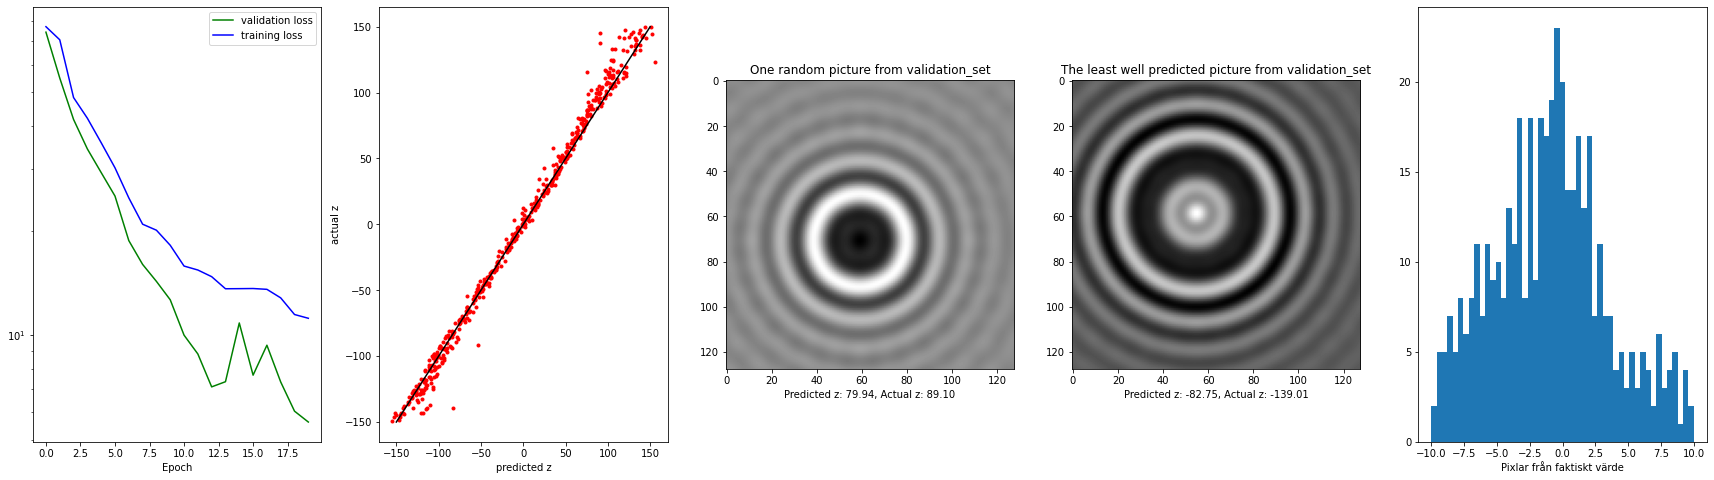

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 10.9780
Epoch 00001: saving model to START/firstmodel.ckpt
20/20 [==============================] - 201s 10s/step - loss: 10.9780 - val_loss: 7.0848
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 11.5630
Epoch 00002: saving model to START/firstmodel.ckpt
20/20 [==============================] - 196s 10s/step - loss: 11.5630 - val_loss: 6.1489
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 11.3017
Epoch 00003: saving model to START/firstmodel.ckpt
20/20 [==============================] - 202s 10s/step - loss: 11.3017 - val_loss: 7.1985
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 11.6477
Epoch 00004: saving model to START/firstmodel.ckpt
20/20 [==============================] - 198s 10s/step - loss: 11.6477 - val_loss: 5.0720
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 11.1377
Epoch 00005: saving model to START/firstmodel.ckpt
20/20

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


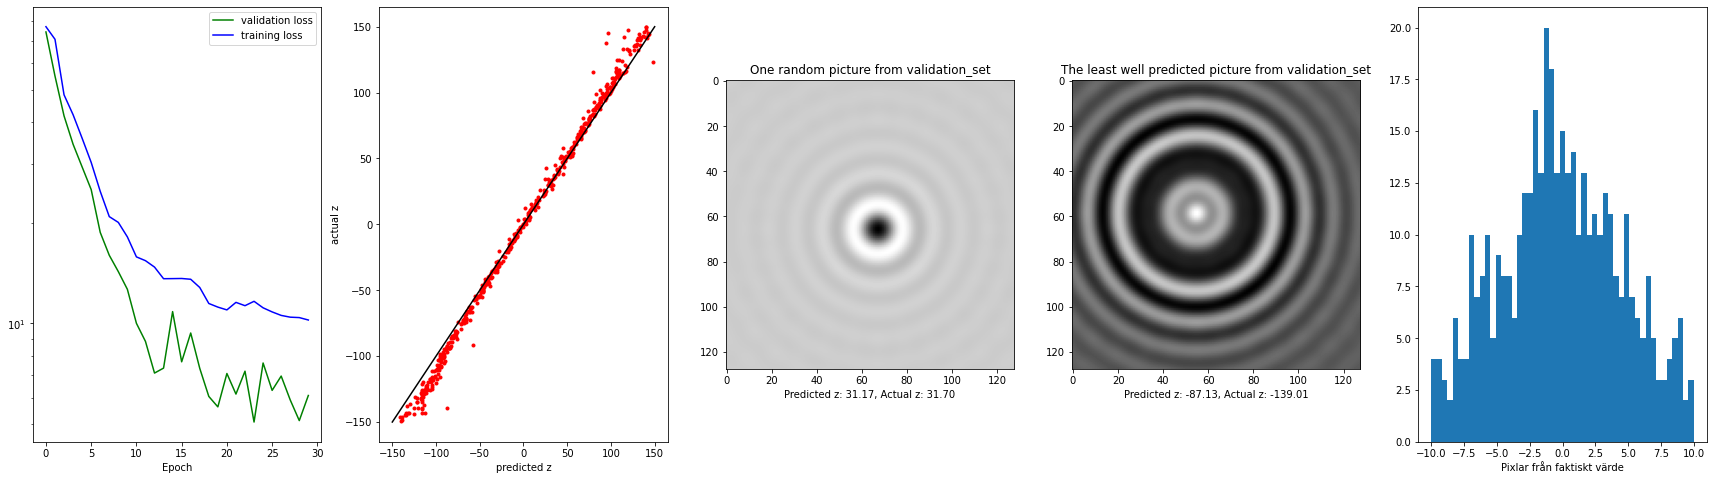

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 10.4654
Epoch 00001: saving model to START/firstmodel.ckpt
20/20 [==============================] - 200s 10s/step - loss: 10.4654 - val_loss: 5.1433
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 10.8688
Epoch 00002: saving model to START/firstmodel.ckpt
20/20 [==============================] - 197s 10s/step - loss: 10.8688 - val_loss: 4.8052
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 10.2280
Epoch 00003: saving model to START/firstmodel.ckpt
20/20 [==============================] - 195s 10s/step - loss: 10.2280 - val_loss: 5.5187
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 9.8931
Epoch 00004: saving model to START/firstmodel.ckpt
20/20 [==============================] - 197s 10s/step - loss: 9.8931 - val_loss: 4.7059
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 10.6372
Epoch 00005: saving model to START/firstmodel.ckpt
20/20 [

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


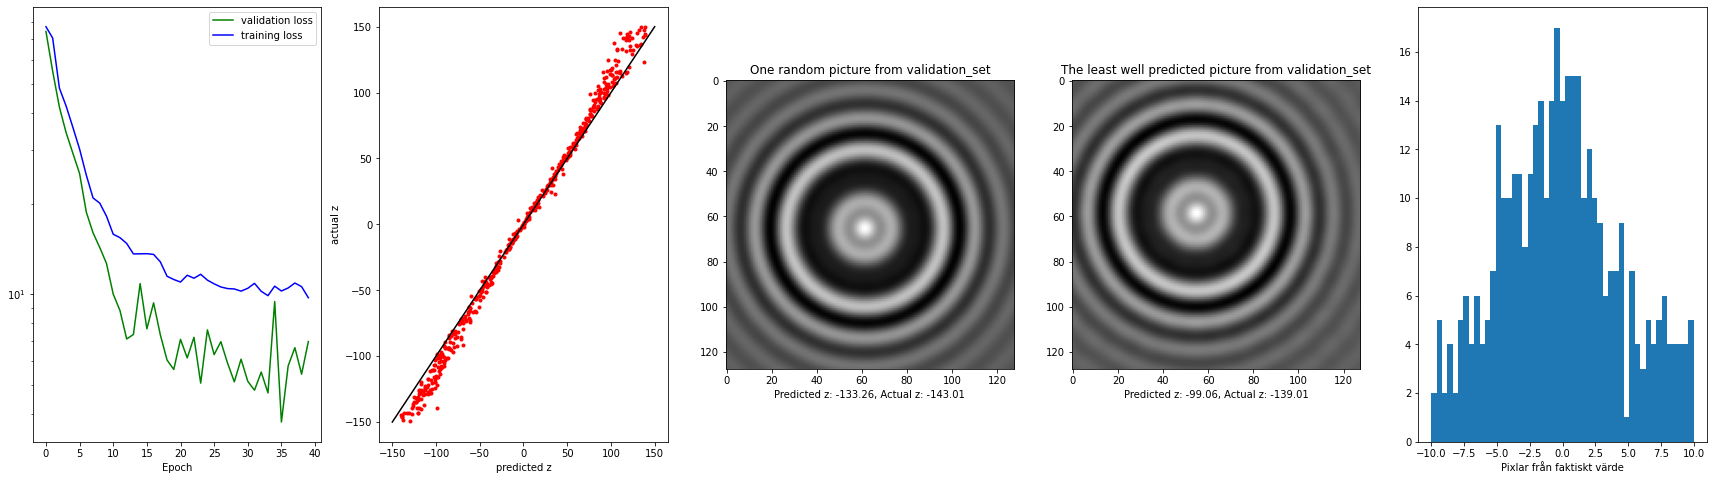

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 9.8224
Epoch 00001: saving model to START/firstmodel.ckpt
20/20 [==============================] - 199s 10s/step - loss: 9.8224 - val_loss: 9.5802
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 9.8096
Epoch 00002: saving model to START/firstmodel.ckpt
20/20 [==============================] - 200s 10s/step - loss: 9.8096 - val_loss: 7.4430
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 9.2810
Epoch 00003: saving model to START/firstmodel.ckpt
20/20 [==============================] - 200s 10s/step - loss: 9.2810 - val_loss: 9.0675
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 9.1221
Epoch 00004: saving model to START/firstmodel.ckpt
20/20 [==============================] - 199s 10s/step - loss: 9.1221 - val_loss: 11.0623
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 10.0927
Epoch 00005: saving model to START/firstmodel.ckpt
20/20 [=====

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


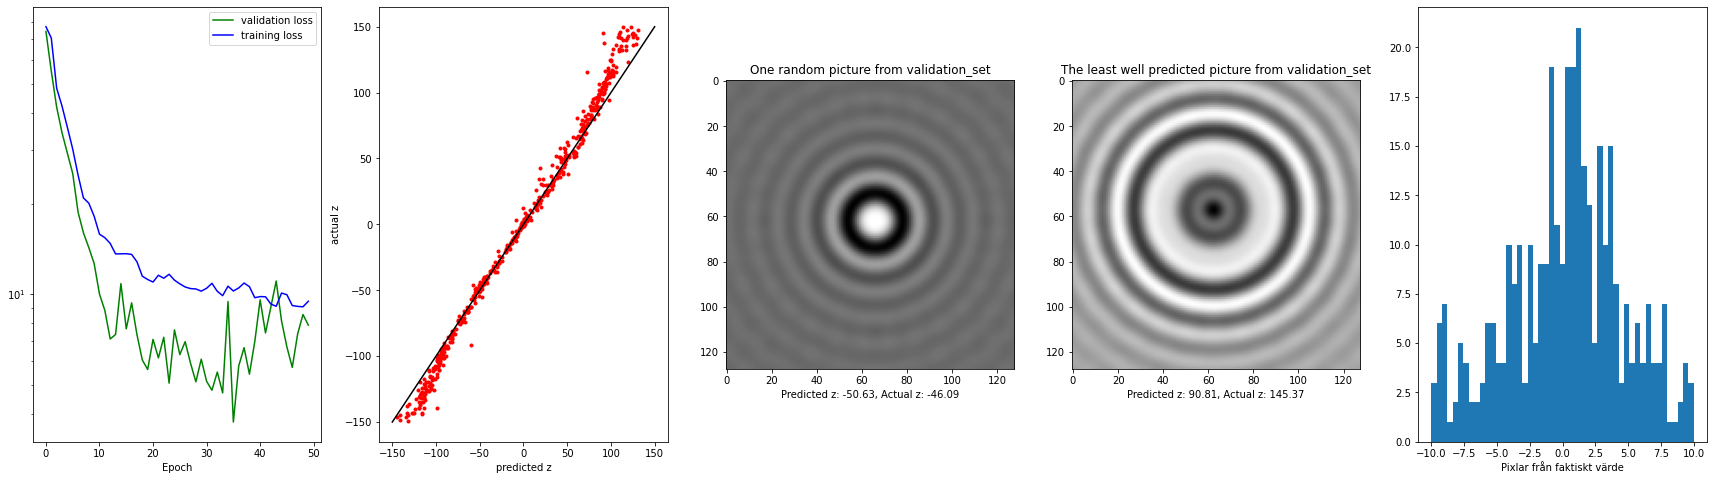

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 8.7084
Epoch 00001: saving model to START/firstmodel.ckpt
20/20 [==============================] - 201s 10s/step - loss: 8.7084 - val_loss: 8.3649
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 9.0649
Epoch 00002: saving model to START/firstmodel.ckpt
20/20 [==============================] - 200s 10s/step - loss: 9.0649 - val_loss: 6.6111
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 9.4971
Epoch 00003: saving model to START/firstmodel.ckpt
20/20 [==============================] - 199s 10s/step - loss: 9.4971 - val_loss: 12.1006
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 8.6886
Epoch 00004: saving model to START/firstmodel.ckpt
20/20 [==============================] - 201s 10s/step - loss: 8.6886 - val_loss: 11.1329
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 8.2259
Epoch 00005: saving model to START/firstmodel.ckpt
20/20 [=====

In [ ]:
import os
from matplotlib import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "START/firstmodel.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

TRAIN_MODEL = True
EPOCHS_BEFORE_PLOT = 10

totalhistory = {"val_loss":[], "loss":[], "epoch":[]}


validation_set_size = 512
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset,
        get_label,
        min_data_size=int(1280),
        max_data_size=int(2560),
        batch_size=128
    )

    with generator:

        for i in range(0,1000,EPOCHS_BEFORE_PLOT):
            h = model.fit(
                generator,
                validation_data=(
                    np.array(validation_set), 
                    np.array(validation_labels)
                ),
                epochs=EPOCHS_BEFORE_PLOT,
                callbacks=[cp_callback],
            )

            totalhistory["val_loss"].extend(h.history["val_loss"])
            totalhistory["loss"].extend(h.history["loss"])            
            totalhistory["epoch"].extend(list(range(i, i+EPOCHS_BEFORE_PLOT)))

            validation_predictions = model.predict(np.array(validation_set))
            random_image_index = np.random.randint(len(validation_set))
            random_selected_image = validation_set[random_image_index]
            random_actual_z = random_selected_image.get_property("z")
            random_predicted_z = validation_predictions[random_image_index,0]

            worst_image_index = np.argmax(np.abs(validation_predictions-np.array(validation_labels)))
            worst_selected_image = validation_set[worst_image_index]
            worst_actual_z = worst_selected_image.get_property("z")
            worst_predicted_z = validation_predictions[worst_image_index,0]

            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (30,8))

            ax1.plot(totalhistory["epoch"], totalhistory["val_loss"], 'g', label="validation loss")
            ax1.plot(totalhistory["epoch"], totalhistory["loss"], 'b', label="training loss")
            ax1.set_xlabel("Epoch")
            ax1.set_yscale('log')
            ax1.legend()

            ax2.plot(validation_predictions, validation_labels, 'r.')
            ax2.plot(np.linspace(-150,150),np.linspace(-150,150),'k')
            ax2.set_xlabel("predicted z")
            ax2.set_ylabel("actual z")

            ax3.set_title("One random picture from validation_set")
            ax3.set_xlabel(f"Predicted z: {random_predicted_z:.2f}, Actual z: {random_actual_z:.2f}")
            ax3.imshow(random_selected_image[:,:,0], cmap="gray")

            ax4.set_title("The least well predicted picture from validation_set")
            ax4.set_xlabel(f"Predicted z: {worst_predicted_z:.2f}, Actual z: {worst_actual_z:.2f}")
            ax4.imshow(worst_selected_image[:,:,0], cmap="gray")

            ax5.hist(validation_predictions-np.array(validation_labels), bins=list(np.linspace(-10,10)))
            ax5.set_xlabel("Pixlar från faktiskt värde")
    
            plt.show()
else:
    model.load_weights(checkpoint_path)

In [ ]:
import numpy as np

dropout = 0.5
num_iter = 20
num_samples = 20

predict_with_dropout = create_dropout_predict_function(model, dropout)

predictions = np.zeros((num_samples, num_iter))
for i in range(num_iter):
    predictions[:,i] = predict_with_dropout(input_data+[1])[0].reshape(-1)

print(predictions)